In [1]:
import pandas as pd
import numpy as py

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#Regression/Modelling Libraries
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

#Load Data
import sklearn.datasets as dta
import re

In [2]:
# constatnts
INPUT_CSV_PATH = "DOHMH_Dog_Bite_Data.csv"
DEFAULT_BREED = 'unknown'

In [3]:
# Load the restaurant ethnicities into a DataFrame
dog_df = pd.read_csv(INPUT_CSV_PATH)

# Display sample data
dog_df.head()

,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


# AGE

In [4]:
# age, clean and convert
# Used XPERT to get ideas on how to tackle age.  There were several types of data scrubbing needed for age with this dataset.
def convert_age_to_decimal(age_str):
    age_str = str(age_str)
    week_match = re.search(r'(\d+)\s*(WKS|W|WEEK|WEEKS)', age_str)
    month_match = re.search(r'(\d+)\s*(MTHS|M|MTH|MONTH)', age_str)
    year_match = re.search(r'(\d+)\s*(YRS|Y|YR|YEAR)', age_str)
    combined_match = re.search(r'(\d+)\s*(&)', age_str)    # Extract Combined Year and Month data when & sign is used.
    
    if week_match:
        weeks = int(week_match.group(1))
        weeks = weeks/52
        decimal_age = weeks    
    elif month_match:
        months = int(month_match.group(1))
        months = months/12
        decimal_age = months
    elif year_match:
        years = int(year_match.group(1))
        decimal_age = years
    elif combined_match:
        yearmonth = re.split(r'\s*&\s*', age_str)
        year = int(yearmonth[0])
        month = int(yearmonth[1])/12
        yearmonth = year + month
        decimal_age = yearmonth
    else:
        # raise ValueError(f'No match for {age_str}')
        try:
            decimal_age = float(age_str)
        except ValueError:
            decimal_age = None
    return decimal_age

In [5]:
print(dog_df.Age.isna().count())
print(dog_df.Age.isna().sum())
print(dog_df.Age.isna().count() - dog_df.Age.isna().sum())

22663
11221
11442


In [6]:
dog_df['age_decimal'] = dog_df['Age'].map(convert_age_to_decimal)

In [7]:
print(dog_df.age_decimal.isna().count())
print(dog_df.age_decimal.isna().sum())
print(dog_df.age_decimal.isna().count() - dog_df.age_decimal.isna().sum())

22663
11276
11387


In [8]:
dog_df.dropna(subset=['age_decimal'], inplace=True)

In [9]:
print(dog_df.age_decimal.isna().count())
print(dog_df.age_decimal.isna().sum())
print(dog_df.age_decimal.isna().count() - dog_df.age_decimal.isna().sum())

11387
0
11387


# Dates and Times

In [10]:
# found a '?' value in the ZipCode column, so eliminating that row from the data set.

dog_df = dog_df.loc[dog_df["ZipCode"] != '?']
dog_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11387 entries, 3 to 22660
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   UniqueID     11387 non-null  int64  
 1   DateOfBite   11387 non-null  object 
 2   Species      11387 non-null  object 
 3   Breed        11298 non-null  object 
 4   Age          11387 non-null  object 
 5   Gender       11387 non-null  object 
 6   SpayNeuter   11387 non-null  bool   
 7   Borough      11387 non-null  object 
 8   ZipCode      9917 non-null   object 
 9   age_decimal  11387 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 900.7+ KB


In [11]:
#Changing the datatype for the DateOfBite column from text to datetime.

dog_df['DateOfBite'] = pd.to_datetime(dog_df['DateOfBite'], errors='coerce')
dog_df['DateOfBite'][:5]

3    2018-01-08
5    2018-01-03
8    2018-01-04
9    2018-01-10
11   2018-01-07
Name: DateOfBite, dtype: datetime64[ns]

In [12]:
# split to year, month, day, dayofweek, weekname and droped the DateOFBite, Species column.

dog_df['Year'] = dog_df['DateOfBite'].dt.year
dog_df['Month'] = dog_df['DateOfBite'].dt.month
dog_df['Day'] = dog_df['DateOfBite'].dt.day 
dog_df['DayOfWeek'] = dog_df['DateOfBite'].dt.dayofweek # day of the week starts(Mon = 0)
dog_df= dog_df.drop(['Species'], axis=1)
dog_df.head()

,UniqueID,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,age_decimal,Year,Month,Day,DayOfWeek
3,4,2018-01-08,Mixed/Other,4,M,False,Brooklyn,11231,4.0,2018,1,8,0
5,6,2018-01-03,BASENJI,4Y,M,False,Brooklyn,11231,4.0,2018,1,3,2
8,9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5Y,M,False,Brooklyn,11235,5.0,2018,1,4,3
9,10,2018-01-10,MIXED,3Y,F,False,Brooklyn,11208,3.0,2018,1,10,2
11,12,2018-01-07,Yorkshire Terrier Crossbreed,7,M,True,Brooklyn,11208,7.0,2018,1,7,6


In [13]:
# Create a dictionary mapping months to seasons

season = {12: 'Winter', 1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall'}

# Create a new column 'Seasons' based on the mapping

dog_df['Seasons'] = dog_df['Month'].map(season)

dog_df.head()

,UniqueID,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,age_decimal,Year,Month,Day,DayOfWeek,Seasons
3,4,2018-01-08,Mixed/Other,4,M,False,Brooklyn,11231,4.0,2018,1,8,0,Winter
5,6,2018-01-03,BASENJI,4Y,M,False,Brooklyn,11231,4.0,2018,1,3,2,Winter
8,9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5Y,M,False,Brooklyn,11235,5.0,2018,1,4,3,Winter
9,10,2018-01-10,MIXED,3Y,F,False,Brooklyn,11208,3.0,2018,1,10,2,Winter
11,12,2018-01-07,Yorkshire Terrier Crossbreed,7,M,True,Brooklyn,11208,7.0,2018,1,7,6,Winter


In [14]:
# Create a dictionary mapping dayofweek to seasons
weekname = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday',
           6: 'Sunday'}

# Create a new column 'season' based on the mapping
dog_df['DayOFWeek'] = dog_df['DayOfWeek'].map(weekname)

dog_df.head()

,UniqueID,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,age_decimal,Year,Month,Day,DayOfWeek,Seasons,DayOFWeek
3,4,2018-01-08,Mixed/Other,4,M,False,Brooklyn,11231,4.0,2018,1,8,0,Winter,Monday
5,6,2018-01-03,BASENJI,4Y,M,False,Brooklyn,11231,4.0,2018,1,3,2,Winter,Wednesday
8,9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5Y,M,False,Brooklyn,11235,5.0,2018,1,4,3,Winter,Thursday
9,10,2018-01-10,MIXED,3Y,F,False,Brooklyn,11208,3.0,2018,1,10,2,Winter,Wednesday
11,12,2018-01-07,Yorkshire Terrier Crossbreed,7,M,True,Brooklyn,11208,7.0,2018,1,7,6,Winter,Sunday


In [15]:
# Establish the bins.
size_bins= [0,4,6]
labels = ["weekday" , "weekend"]
# Categorize the weenday based on the bins
# Use `pd.cut` on the "DayOfWeek" column of the `dog_df` DataFrame.
dog_df["WeekDay"]=pd.cut(dog_df["DayOfWeek"],size_bins,labels=labels,include_lowest=True)
dog_df.head(5).sort_values( by = "DayOfWeek" ,ascending=False)

,UniqueID,DateOfBite,Breed,Age,Gender,SpayNeuter,Borough,ZipCode,age_decimal,Year,Month,Day,DayOfWeek,Seasons,DayOFWeek,WeekDay
11,12,2018-01-07,Yorkshire Terrier Crossbreed,7,M,True,Brooklyn,11208,7.0,2018,1,7,6,Winter,Sunday,weekend
8,9,2018-01-04,American Pit Bull Mix / Pit Bull Mix,5Y,M,False,Brooklyn,11235,5.0,2018,1,4,3,Winter,Thursday,weekday
5,6,2018-01-03,BASENJI,4Y,M,False,Brooklyn,11231,4.0,2018,1,3,2,Winter,Wednesday,weekday
9,10,2018-01-10,MIXED,3Y,F,False,Brooklyn,11208,3.0,2018,1,10,2,Winter,Wednesday,weekday
3,4,2018-01-08,Mixed/Other,4,M,False,Brooklyn,11231,4.0,2018,1,8,0,Winter,Monday,weekday


## BREED

In [16]:
def column_info(df, col):
    print(f'nunique: {df[col].nunique()}')
    print(f'count: {df[col].count()}')
    print(df[col].value_counts().head(22))

In [17]:
# mixes with consildated breeds
def consolidated_breed_mix_removal(execute=True):
    for target in breed_consolidation:
        contains_target_mask = dog_df.breed_norm.str.contains(target)
        not_target_mask = dog_df.breed_norm != target
        to_replace_mask = contains_target_mask & not_target_mask
        if execute:
            dog_df.loc[to_replace_mask, 'breed_norm'] = DEFAULT_BREED
        else:
            print(dog_df.loc[to_replace_mask, 'breed_norm'].values)

In [18]:
dog_df.Breed = dog_df.Breed.fillna(DEFAULT_BREED)

In [19]:
dog_df['breed_norm'] = dog_df['Breed'].str.lower()
dog_df.breed_norm.replace
column_info(dog_df, 'breed_norm')

nunique: 1434
count: 11387
breed_norm
pit bull                                1410
shih tzu                                 473
american pit bull mix / pit bull mix     453
unknown                                  392
german shepherd                          362
mixed/other                              338
chihuahua                                323
mixed breed                              314
american pit bull terrier/pit bull       299
yorkshire terrier                        286
mixed                                    247
maltese                                  227
siberian husky                           174
labrador retriever                       158
rottweiler                               141
jack russ                                135
labrador retriever crossbreed            135
poodle, standard                         113
cocker spaniel                           112
shiba inu                                110
american staffordshire terrier           109
bull dog, english

In [20]:
breed_res = {
    re.compile(r".*pit.?bull.*", re.IGNORECASE): 'pit bull',
    re.compile(r".*mix.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*/.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*\s+x.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*-x.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*mxied.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*boxer beagle.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*border collile, rotweiller, lab, boxer.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*exotic american bully.*", re.IGNORECASE): 'pit bull',
    re.compile(r".*bord.*x.*", re.IGNORECASE): 'french mastiff',
    re.compile(r".*&.*", re.IGNORECASE): DEFAULT_BREED,
    re.compile(r".*cross.*", re.IGNORECASE): DEFAULT_BREED,
    # order may be important after this point
    re.compile(r".*collie.*", re.IGNORECASE): 'collie',
     # these patterns were developed after rare breeds removal
}
for breed_re in breed_res:
    dog_df.breed_norm = dog_df['breed_norm'].str.replace(breed_re, breed_res[breed_re], regex=True)
column_info(dog_df, 'breed_norm')

nunique: 388
count: 11387
breed_norm
unknown                           3460
pit bull                          2500
shih tzu                           473
german shepherd                    362
chihuahua                          323
yorkshire terrier                  286
maltese                            227
siberian husky                     174
labrador retriever                 158
rottweiler                         141
jack russ                          135
poodle, standard                   113
cocker spaniel                     112
shiba inu                          110
american staffordshire terrier     109
bull dog, english                   92
beagle                              86
golden retriever                    84
bull dog                            80
bull dog, french                    79
pomeranian                          75
boxer                               57
Name: count, dtype: int64


In [21]:
breed_consolidation = {
    'jack russ': ['jack russ', 'jack russell terrier', 'terrier, jack russ'],
    DEFAULT_BREED: ['labrador boxer'],
    'poodle': ['poodle, miniature', 'poodle, standard', 'poodle, toy', 'poodle', 'large poodle', 
               'french poodle'],
    'poo': [],
    'doodle': [],
    'pit bull': ['american staffordshire terrier'],
    'retriever': ['labrador retriever', 'golden retriever', 'nova scotia duck tolling retriever', 'labarador retriever', 'chesapeake bay retriever'],
    'dachshund': ['doxxin','dachshund smooth coat', 'dachshund, wirehaired, miniature', 
                  'dachshund, wirehaired', 'dachshund smooth coat miniature','dachshund, long haired', 
                  'dachshund','dachshund, long haired miniature', 'dachshund, miniature', 
                  'dachshund miniature', 'daschound', 'daschund'],
     # these patterns were developed after rare breeds removal
    'bull dog': ['bull dog, english', 'bull dog', 'bull dog, french'],
}
for target, patterns in breed_consolidation.items():
    for pat in patterns:
        # print(f'replacing {pat} with {target}')
        dog_df.breed_norm = dog_df.breed_norm.str.replace(pat, target)
consolidated_breed_mix_removal(execute=True)
print(dog_df['breed_norm'].count())
column_info(dog_df, 'breed_norm')

11387
nunique: 320
count: 11387
breed_norm
unknown              3819
pit bull             2609
shih tzu              473
german shepherd       362
chihuahua             323
yorkshire terrier     286
bull dog              251
retriever             249
maltese               227
siberian husky        174
rottweiler            141
jack russ             138
cocker spaniel        112
shiba inu             110
dachshund              95
beagle                 86
pomeranian             75
bichon frise           57
boxer                  57
boston terrier         56
havanese               54
cane corso             54
Name: count, dtype: int64


### due to project time constraints we had to do this rather than continue to add more patterns

In [22]:
rare_breeds = ['boxer', 'bichon frise', 'boston terrier', 'havanese', 'chow chow',
       'cane corso', 'australian shepherd', 'doberman pinscher',
       'lhasa apso', 'american bully', 'miniature pinscher', 'pekingese',
       'akita', 'staffordshire bull terrier', 'west high white terrier',
       'collie', 'terrier', 'bull terrier', 'wheaton terrier',
       'schnauzer, miniature', 'puggle', 'belgian malinois', 'great dane',
       'rhodesian ridgeback', 'mastiff, bull', 'pug', 'corgi',
       'american eskimo', 'shar-pei, chinese', 'mastiff', 'mutt',
       'schnauzer, standard', 'rat terrier', 'cairn terrier',
       'jindo dog,', 'weimaraner', 'labrador', 'husky', 'morkie',
       'basenji', 'australian cattle dog', 'hound', 'cotton de tulear',
       'scottish terrier', 'bernese mountain', 'dalmatian', 'vizsla',
       'portuguese water dog', 'silky terrier', 'saint bernard',
       'border terrier', 'greyhound', 'tibetan terrier', 'newfoundland',
       'brussels griffon', 'alaskan klee kai', 'basset hound',
       'welsh corgi, pembroke', 'american bull dog', 'american bulldog',
       'bulldog', 'cavalier king charles spaniel', 'samoyed',
       'brittany spaniel', 'mastiff, tibetan', 'norfolk terrier', 'bully',
       'pointer, german shorthaired', 'mini australian shepherd',
       'french mastiff', 'pointer', 'nova scotia duck tolling retriever',
       'german pinscher', 'papillon', 'mastiff, old english',
       'toy fox terrier', 'english springer spaniel',
       'english cocker spaniel', 'unsure', 'welsh corgi, cardigan',
       'airedale terrier', 'springer spaniel', 'cocker spaniel, american',
       'black mouth cur', 'australian cattle', 'great pyrenees',
       'wire fox terrier', 'pomski', 'kerry blue terrier', 'schnoodle',
       'bloodhound', 'sheperd', 'belgian shepherd',
       'coonhound, black and tan', 'australian cattledog', 'plott hound',
       'staffordshire', 'schnauzer, giant', 'bouvier des flandres',
       'pomsky', 'chinese crested', 'catahoula leopard', 'schnauzer',
       'clumber spaniel', 'coonhound, treeing walker', 'yorkie',
       'shepherd', 'blue tick hound', 'mastiff, neapolitan',
       'australian silky terrier', 'pharoh hound', 'english bull terrier',
       'belgian sheepdog', 'potcake', 'carolina dog',
       'black russian terrier', 'patterdale terrier',
       'glen of imaal terrier', 'catahoula leopard dog',
       'alaskan malamute', 'sheepdog', 'lowchen', 'shetland sheepdog',
       'victorian bulldog', 'alaskan husky', 'golden doddle',
       'english bull dog', 'mini bull terrier', 'cattle dog',
       'medium size dog', 'zuchon', 'norwich terrier', 'french bull dog',
       'unkown', 'dandie dinmont terrier', 'stafford', 'pocket bully',
       'english bulldog terrier', 'hatchie', 'russian terrier',
       'large dog', 'wirehaired pointing griffon', 'borzoi',
       'bulldog, american', 'husky labrador',
       'portuguese podengo pequeno', 'mini pincher',
       'nova scotia duck tollier', 'chinese crested hairless',
       'felky terrier', 'welsh springer spaniel', 'west highland terr',
       'potcake dog', 'shichon', 'puli', 'australian sheep dog',
       'boston border terrier', 'alaskan malmute', 'catahoula cur',
       'teacup maltese', 'shichi', 'queensland blue healer',
       'belgium shepard', 'sharpei', 'australian shpherd',
       'pocket beagle', 'not sure, rescue', 'bolognese bichon',
       'english bulldog', 'red nose pit', 'staffordshire terrier',
       'pomeranian english spaniel', 'parson terr', 'irish terrier',
       'schipperkee', 'irish wolfhound', 'feist', 'miki',
       'parson russell terrieer', 'cavashu', 'chinese tien yun chu',
       'marquis', 'maltese terrier', 'central asian shepherd',
       'malti tzu', 'dogo', 'yorkie chon', 'english sheepdog',
       'toy yorkie', 'american bull', 'russell terr', 'boerboel',
       'malshi', 'beagle hound', 'russell terrier', 'italian masiff',
       'italian masif', 'laborador mastiff', 'markey',
       'king charles cavlier', 'malamute', 'parson russell terrier',
       'bully breed', 'amer bull terrier', 'white point griffon',
       'mini golden doddle', 'dogo argentino', 'briard', 'englih bulldog',
       'african boerboel', 'sheep dog', 'tibetan mastiff',
       'multi collar terrier', 'english mastiff', 'italian king corso',
       'coton de tulear', 'westies', 'belgian turvuren', 'westy',
       'alapaha bulldog', 'persa canario', 'english setter',
       'miniature schnauzer', 'aust cattle dog', 'harrier hound',
       'labarador retriever', 'australian terrier', 'english toy spaniel',
       'mini golden retrever', 'catahoula', 'unnkown', 'big size dog',
       'german wirehaired pointer', 'austrailian shepard', 'hot dog',
       'blue healer', 'king korso', 'corgie', 'small dog', 'lagotte',
       'king charles', 'japanese shiba', 'lapso',
       'miniature australian sheperd', 'petit basset griffon vendeen',
       '2 bull terrier dogs', 'peagle', 'shiloh shepherd',
       'miniature american shepard', 'japanese spitz', 'small',
       'lakeland terrier', 'asian sheperd', 'sapsal', 'italian greyhound',
       'teacup chi hua hua', 'russian wolfhound',
       'english staffordshire bull terrier', 'uncertain',
       'terrier, kerry blue', 'shepard', 'english staffordshire terrier',
       'shi-po', 'medium breed', 'shih tzu pug', 'boykin spaniel',
       'english pointer', 'mexican hairless', 'pitbll terrier',
       'vizsla breed', 'arubian cunucu', 'chinese crested powder puff',
       'wire hair terrier', 'mini australian shpherd', 'english bullbog',
       'british bulldog', 'walkerhound', 'german shepard',
       'spinone italiano', 'large', 'fox hound', 'italian mastiff',
       'parson russellterr', 'staffordshire terr', 'shorky',
       'sherlyn shepherd', 'eng setter', 'korean sapsali',
       'doberman and labrador', 'english brindle', 'cesky terrier',
       'dandie dinmont', 'australian blue heeler', 'llewelin setter',
       'soft coated wheaten terrier', 'chesapeake bay retriever',
       'westie terrier', 'beauceron', 'american hairless terrier',
       'american bull terrier', 'spanish water dog',
       'mini american husky', 'saluki', 'american coonhound',
       'tibetan spaniel', 'blue lacy', 'whippet', 'soft wheaton terrier',
       'micro bully', 'dunker']
rare_breed_mask = dog_df.breed_norm.isin(rare_breeds)
dog_df.loc[rare_breed_mask, 'breed_norm'] = None
column_info(dog_df, 'breed_norm')

nunique: 17
count: 9530
breed_norm
unknown              3819
pit bull             2609
shih tzu              473
german shepherd       362
chihuahua             323
yorkshire terrier     286
bull dog              251
retriever             249
maltese               227
siberian husky        174
rottweiler            141
jack russ             138
cocker spaniel        112
shiba inu             110
dachshund              95
beagle                 86
pomeranian             75
Name: count, dtype: int64


In [23]:
#prof had us drop Unknown and TBD due to time constraints
clean_df = dog_df.loc[dog_df["breed_norm"] != 'unknown']

In [24]:
clean_df.breed_norm.value_counts()
column_info(clean_df, 'breed_norm')

nunique: 16
count: 5711
breed_norm
pit bull             2609
shih tzu              473
german shepherd       362
chihuahua             323
yorkshire terrier     286
bull dog              251
retriever             249
maltese               227
siberian husky        174
rottweiler            141
jack russ             138
cocker spaniel        112
shiba inu             110
dachshund              95
beagle                 86
pomeranian             75
Name: count, dtype: int64


In [25]:
age_df = clean_df.groupby('age_decimal').size().reset_index()
age_df.columns = ['age_decimal', 'num_bites']
age_df.head()

,age_decimal,num_bites
0,0.083333,2
1,0.134615,1
2,0.153846,2
3,0.166667,27
4,0.192308,1


In [26]:
age_df.corr()

,age_decimal,num_bites
age_decimal,1.000000,-0.018141
num_bites,-0.018141,1.000000


## Future breed 

In [27]:
# rare_mask = dog_df.breed_norm.value_counts() <= 75
# print(dog_df.breed_norm.value_counts()[rare_mask].sum())
# rare_breeds = dog_df.breed_norm.value_counts()[rare_mask].index
# print(len(rare_breeds))
# column_info(dog_df, 'breed_norm')

In [28]:
# dog_df.loc[dog_df.breed_norm != DEFAULT_BREED, 'Age'].count()

In [29]:
# dog_df.loc[~rare_mask]

In [30]:
# target = 'poodle'
# contains_target_mask = dog_df.breed_norm.str.contains(target)
# not_target_mask = dog_df.breed_norm != target
# to_replace_mask = contains_target_mask & not_target_mask
# dog_df.loc[to_replace_mask, 'breed_norm'] = DEFAULT_BREED

In [31]:
# #Pattern investigation cell
# breed_mask = dog_df.breed_norm.str.contains('bull')
# print(breed_mask.sum())
# dog_df.loc[breed_mask, 'breed_norm'].unique()

In [32]:
# #regex test cell
# test_re = re.compile(r".*retriever.*", re.IGNORECASE)
# test_mask = dog_df['breed_norm'].str.contains(test_re, regex=True)
# column_info(dog_df[test_mask], 'breed_norm')

In [33]:
# dog_df.loc[test_mask, 'breed_norm'].unique()

In [34]:
# dog_df.breed_norm = dog_df['breed_norm'].str.replace(test_re, DEFAULT_BREED, regex=True)
# column_info(dog_df, 'breed_norm')

In [35]:
# breed_mask.unique()

### BREED

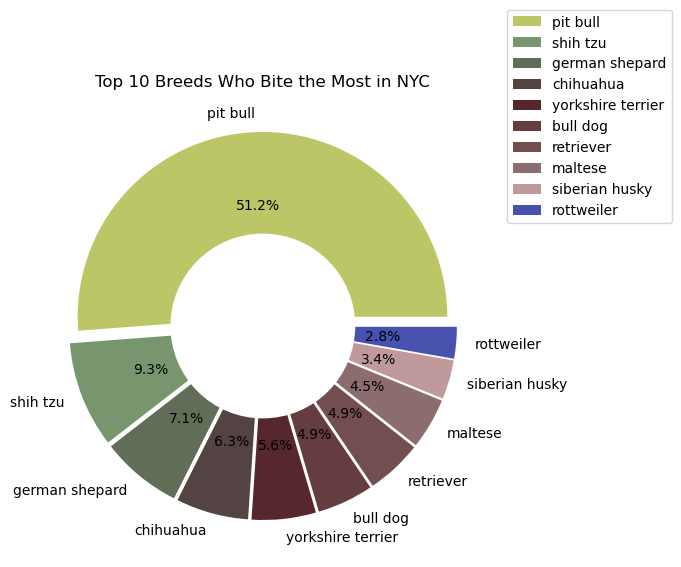

In [36]:
sizes = [2609, 473, 362, 323, 286, 251, 249, 227, 174, 141]  # Number of female and male mice
labels = ['pit bull', 'shih tzu', 'german shepard', 'chihuahua', 'yorkshire terrier', 'bull dog', 'retriever', 'maltese', 'siberian husky', 'rottweiler']
colors = ['#BDC667','#77966D', '#626D58', '#544343', '#56282D', '#653C40', '#734E51', '#8C6D6F', '#C0999C', '#4652AD']
# Set the explode levels for each slice
explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]  # Explode the first slice (Female)
# Step 2: Make the canvas
plt.figure(figsize=(8, 6))
# Step 3: Make the plot
plt.pie(sizes, labels=labels, colors=colors, explode=explode, autopct='%1.1f%%', startangle=0)
# Step 3.5: Add in the donut hole
center_circle = plt.Circle((0, 0), .5, fc='white')
fig = plt.gcf()
# Adding Circle in Pie chart
fig.gca().add_artist(center_circle)
plt.title('Top 10 Breeds Who Bite the Most in NYC')
plt.legend(['pit bull', 'shih tzu', 'german shepard', 'chihuahua', 'yorkshire terrier', 'bull dog', 'retriever', 'maltese', 'siberian husky', 'rottweiler', 'jack russ', 'cocker spaniel', 'shiba inu', 'dachshund', 'beagle', 'pomeranian'])
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.2))

# plt.ylabel("Sex")
# Display the plot
plt.show()

## SEASONS

In [37]:
season_df = clean_df.groupby('Seasons').size().reset_index()
season_df.columns = ['season', 'num_bites']
season_df.head()

,season,num_bites
0,Fall,1776
1,Spring,1991
2,Summer,2212
3,Winter,1589


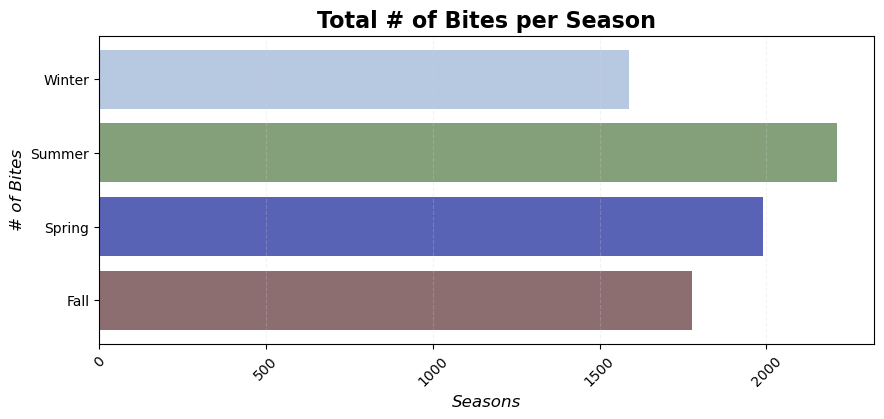

In [38]:
x = season_df.season
y = season_df.num_bites
colors = ['#805E61', '#4652AD', '#77966D', '#B0C4DE']
plt.figure(figsize=(10, 4))
plt.barh(x, y, color=colors,alpha=0.90, align="center")
# Add labels and title
plt.xlabel('Seasons', fontstyle='italic', fontsize=12)
plt.ylabel('# of Bites', fontstyle='italic', fontsize=12)
plt.title('Total # of Bites per Season', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(color='lightgrey', axis='x', linestyle='--', alpha=0.25)
#Display the plot
plt.show()

## Days of Week

In [39]:
day_of_week_df = clean_df.groupby('DayOFWeek').size().reset_index().sort_index(ascending=False)
day_of_week_df.columns = ['DayOFWeek', 'num_bites']
day_of_week_df.head(7)

,DayOFWeek,num_bites
6,Wednesday,1057
5,Tuesday,1015
4,Thursday,1058
3,Sunday,1133
2,Saturday,1246
1,Monday,1021
0,Friday,1038


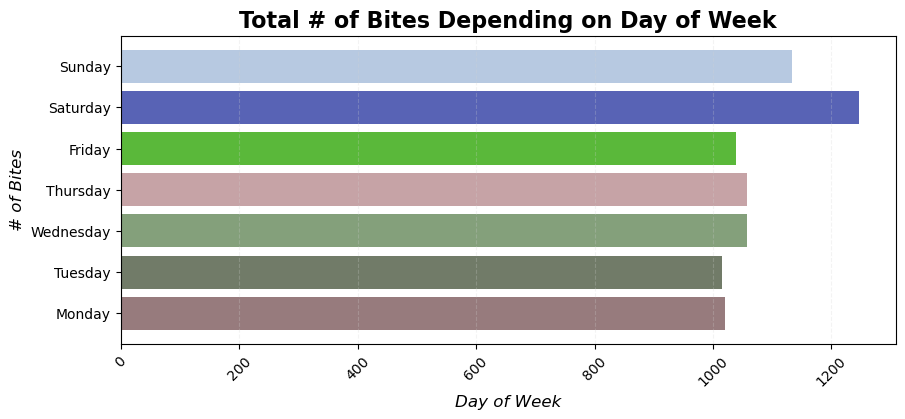

In [40]:
x = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
y = [1021, 1015, 1057, 1058, 1038, 1246, 1133]
colors = ['#8C6D6F', '#626D58', '#77966D', '#C0999C', '#48B124', '#4652AD', '#B0C4DE']
plt.figure(figsize=(10, 4))
plt.barh(x, y, color=colors,alpha=0.90, align="center")
# Add labels and title
plt.xlabel('Day of Week', fontstyle='italic', fontsize=12)
plt.ylabel('# of Bites', fontstyle='italic', fontsize=12)
plt.title('Total # of Bites Depending on Day of Week', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(color='lightgrey', axis='x', linestyle='--', alpha=0.25)
#Display the plot
plt.show()

## Bites per Year

In [41]:
year_df = clean_df.groupby('Year').size().reset_index().sort_index(ascending=False)
year_df.columns = ['year', 'num_bites']
year_df.head(10)

,year,num_bites
6,2021,624
5,2020,656
4,2019,1097
3,2018,1028
2,2017,1392
1,2016,1351
0,2015,1420


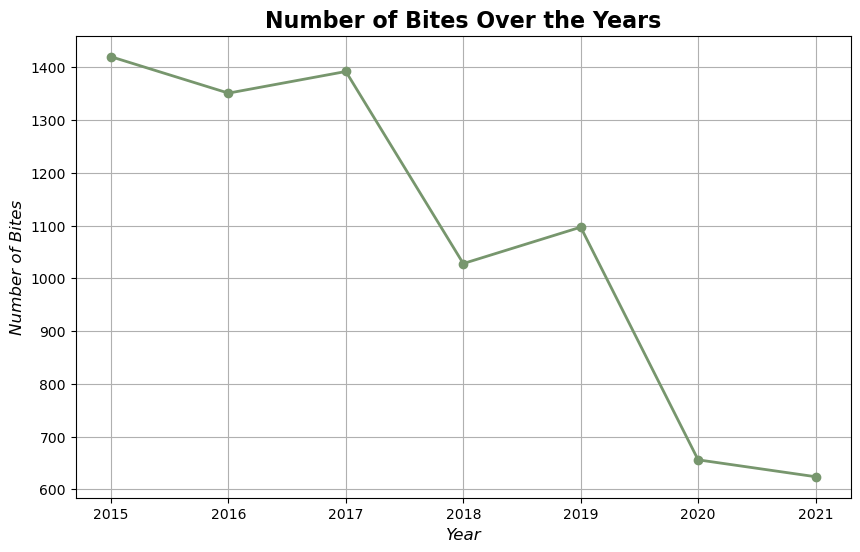

In [42]:
years = [2015, 2016, 2017, 2018, 2019, 2020, 2021]
num_bites = [1420, 1351, 1392, 1028, 1097, 656, 624]
# Plot the data using Matplotlib:
plt.figure(figsize=(10, 6))
plt.plot(years, num_bites, marker='o', color='#77966D', linestyle='-', linewidth=2)
plt.xlabel('Year', fontstyle="italic", fontsize=12)
plt.ylabel('Number of Bites', fontstyle='italic', fontsize=12)
plt.title('Number of Bites Over the Years', fontsize=16, fontweight='bold')
plt.grid(True)
plt.show()

## Distribution Plots

C:\Anaconda\envs\dev\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


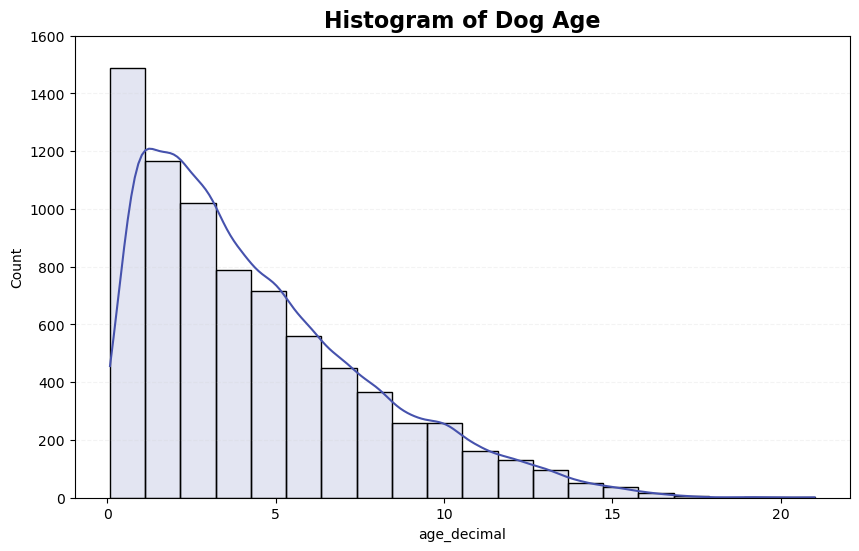

In [43]:
## Step 1: get the data
x = clean_df.age_decimal
# create the plot
plt.figure(figsize=(10,6))
sns.histplot(clean_df.age_decimal, color="#4652AD", kde=True, bins=20, alpha=0.15)
# customizations
# sns.kdeplot(clean_df.age_decimal, color='blue')
plt.title('Histogram of Dog Age', fontsize=16, fontweight='bold')
plt.ylim(0, 1600)
plt.grid(color='lightgrey', axis='y', linestyle='--', alpha=0.25)
# show
plt.show()

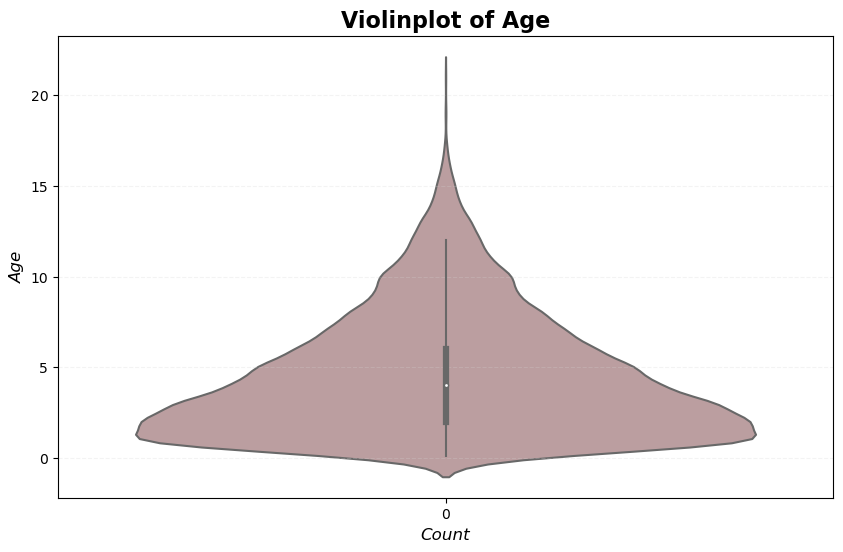

In [44]:
# Step 1: get the data
# x = clean_df.age_decimal
# create the plot
plt.figure(figsize=(10,6))
sns.violinplot(clean_df.age_decimal.values, color='#C0999C')
# customizations
plt.xlabel('Count', fontstyle='italic', fontsize=12)
plt.ylabel('Age', fontstyle='italic', fontsize=12)
plt.title('Violinplot of Age', fontsize=16, fontweight='bold')
# plt.ylim(-1000, 17000)
plt.grid(color='lightgrey', axis='y', linestyle='--', alpha=0.25)
# show
plt.show()

## Scatter Plot & Linear Regression

In [45]:
age_df = clean_df.groupby('age_decimal').size().reset_index()
age_df.columns = ['age_decimal', 'num_bites']
age_df.head()

,age_decimal,num_bites
0,0.083333,2
1,0.134615,1
2,0.153846,2
3,0.166667,27
4,0.192308,1


The r-squared is: 0.00032908540749924215


C:\Users\moore\AppData\Local\Temp\ipykernel_18068\1453702006.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, regress_values, "r-", color='#48B124') # plot the line of best fit


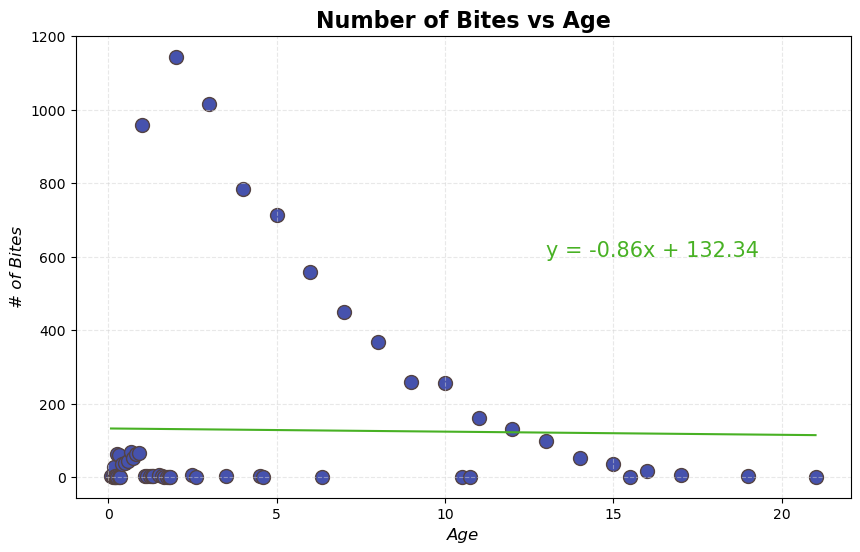

In [46]:
# USING LINREGRESS
x_values = age_df.age_decimal
y_values = age_df.num_bites
# makes the line of best fit
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept # calculate the predictions
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
# make the plot
# Step 2: Make the canvas
plt.figure(figsize=(10, 6))
# Step 3: Make the basic plot
plt.scatter(x_values, y_values, facecolor="#4652AD", edgecolor="#544343", s=100)
plt.plot(x_values, regress_values, "r-", color='#48B124') # plot the line of best fit
# Step 4: Customizations
plt.xlabel('Age', fontsize=12, fontstyle="italic")
plt.ylabel('# of Bites', fontsize=12, fontstyle="italic")
plt.title('Number of Bites vs Age', fontweight='bold', fontsize=16)
plt.grid(color='lightgrey', linestyle = '--', alpha=0.5)
plt.annotate(line_eq,(13, 600),fontsize=15,color='#48B124')
print(f"The r-squared is: {rvalue**2}")
plt.show()